In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#%matplotlib notebook
%matplotlib inline

In [18]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/training')

In [19]:
import sys
sys.path.append(ROOT)

In [20]:
import torch
import pickle
import pandas as pd
import matplotlib.pylab as pylab

from utils.plot.abc_parameterizations.results import *

## Set variables

In [21]:
L = 6
WIDTH = 1024
BASE_LR = 0.01
BATCH_SIZE = 512
BIAS = False
N_TRIALS = 5
MODEL_NAME = 'standard_fc_ip' # 'fc_ipllr', 'standard_fc_ip'
DATASET = 'mnist'

FONTSIZE = 12
FIGSIZE = (10, 6)

ACT_KEY_TO_NAME = {'relu': 'ReLU',
                   'gelu': 'GeLU',
                   'elu': 'ELU',
                   'tanh': 'tanh'}


experiments_dir = os.path.join(ROOT, 'experiments')
base_experiment = '{}_{}'.format(MODEL_NAME, DATASET)
fig_dir = os.path.join(ROOT, FIGURES_DIR, DATASET)

params = {'legend.fontsize': FONTSIZE,
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE}
pylab.rcParams.update(params)

## Process results

In [22]:
results = dict()
for activation in ACT_KEY_TO_NAME.keys():
    results[activation] = get_trial_results([L], [WIDTH], N_TRIALS, experiments_dir, base_experiment, activation, 
                                            BASE_LR, BATCH_SIZE, BIAS)

In [8]:
epoch_res = dict()
step_res = dict()
for activation in ACT_KEY_TO_NAME.keys():
    epoch_res_, step_res_ = get_epoch_step_results_from_trials(results[activation], 
                                                               pop_keys=('lrs', 'all_outputs', 'all_losses'))
    epoch_res[activation] = epoch_res_
    step_res[activation] = step_res_

In [9]:
# generate dataframe for easy plotting with seaborn lineplot
results_df = pd.DataFrame(columns=['step', 'mean absolute output', 'loss', 'activation'])
key_to_metric_name_results = {'all_outputs': 'mean absolute output', 
                              'all_losses': 'loss'}

idx_start_trial = 0
for activation in step_res.keys():
    for trial in step_res[activation][L][WIDTH]:
        for i, metric_value in enumerate(trial['all_outputs']):
            results_df.loc[idx_start_trial + i, ['step', 'mean absolute output', 'loss', 'activation']] = \
                [i, trial['all_outputs'][i].item(), trial['all_losses'][i].item(), ACT_KEY_TO_NAME[activation]]
        idx_start_trial += len(trial['all_outputs'])

results_df.loss = results_df.loss.astype(float)
results_df['mean absolute output'] = results_df['mean absolute output'].astype(float)

## Plots

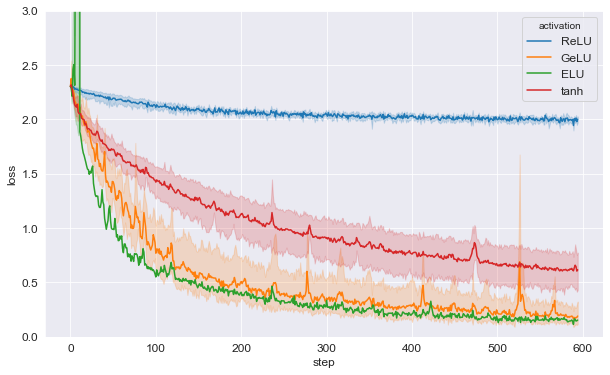

In [11]:
plt.figure(figsize=FIGSIZE)
plt.ylim(0, 3)

g = sns.lineplot(x="step", y="loss", hue="activation", data=results_df)

fig_path = os.path.join(fig_dir, '{}_loss.png'.format(MODEL_NAME))
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

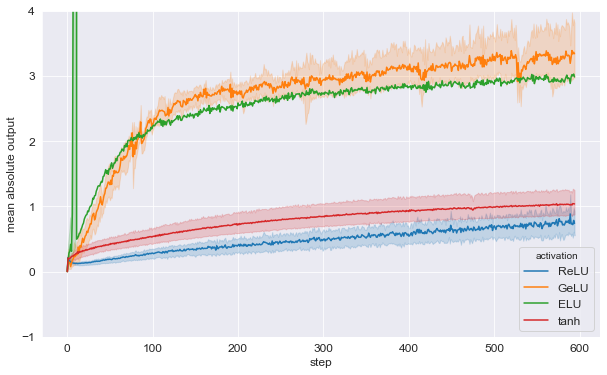

In [15]:
plt.figure(figsize=FIGSIZE)
plt.ylim(-1, 4)

g = sns.lineplot(x="step", y="mean absolute output", hue="activation", data=results_df)

fig_path = os.path.join(fig_dir, '{}_output.png'.format(MODEL_NAME))
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

## Test accuracies

In [13]:
test_accuracies = {activation: [results[activation][L][WIDTH][idx]['test'][0]['accuracy'] 
                                for idx in range(N_TRIALS)] 
                   for activation in ACT_KEY_TO_NAME.keys()}
test_accuracies

{'relu': [0.0957999974489212,
  0.11349999904632568,
  0.147599995136261,
  0.11559999734163284,
  0.09799999743700027],
 'gelu': [0.8963000178337097,
  0.9617999792098999,
  0.9557999968528748,
  0.9616000056266785,
  0.9537000060081482],
 'elu': [0.9351999759674072,
  0.09799999743700027,
  0.9506999850273132,
  0.9656999707221985,
  0.9671000242233276],
 'tanh': [0.9401999711990356,
  0.9641000032424927,
  0.9269000291824341,
  0.9624000191688538,
  0.9416000247001648]}

In [14]:
for activation in ACT_KEY_TO_NAME.keys():
    print(activation, np.mean(test_accuracies[activation]))

relu 0.1140999972820282
gelu 0.9458400011062622
elu 0.7833399906754493
tanh 0.9470400094985962
